#### Во оваа тетратка ќе се обидеме да ги кластерираме податоците според обележјата кои се покажаа како корисни во делот со селекција на обележја.

Ги вчитуваме податоците како претходно, и ги селектираме обележјата кои не интересираат. 

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns
import shutil 
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler


In [3]:
X_train = np.load("nparrs/X_train.npy")
X_test = np.load("nparrs/X_test.npy")
X_val = np.load("nparrs/X_val.npy")
y_train = np.load("nparrs/y_train.npy")
y_test = np.load("nparrs/y_test.npy")
y_val = np.load("nparrs/y_val.npy")

In [4]:
channels = [
    'Fp1','Fp2','F7','F3','Fz','F4','F8','FC3','FCz','FC4',
    'T7','C3','Cz','C4','T8','CP3','CPz','CP4','P7','P3',
    'Pz','P4','P8','O1','Oz','O2'
]

features = [
    "mean_val", "std_val", "rms_val", "kurtosis_val", "skewness_val",
    "activity", "mobility", "complexity", "shannon_entropy_val",
    "spectral_entropy_delta", "spectral_entropy_theta", "spectral_entropy_alpha", 
    "spectral_entropy_beta", "spectral_entropy_gamma",
    "delta_power", "theta_power", "alpha_power", "beta_power", "gamma_power",
    "wavelet_entropy_val", "theta_beta_ratio", "katz_fd_val", "petrosian_fd_val", "higuchi_fd_val"
]


In [5]:
def create_dataframe(data, channels, features):
    
    num_channels = len(channels)
    num_features = len(features)
    column_names = [f'{channel}_{feature}' for channel in channels for feature in features]
    df = pd.DataFrame(data, columns=column_names)
    return df

In [6]:
training_df_initial = create_dataframe(X_train, channels, features)
testing_df = create_dataframe(X_test, channels, features)
validation_df = create_dataframe(X_val, channels, features)

In [7]:
training_df_initial['diagnosis'] = y_train
testing_df['diagnosis'] = y_test
validation_df['diagnosis'] = y_val

In [8]:
def remove_outliers(df:pd.DataFrame) -> pd.DataFrame:

    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df)

    pca = PCA(n_components=3)  
    pca.fit(scaled_data)
    pca_components = pca.transform(scaled_data)

    reconstructed_data = pca.inverse_transform(pca_components)
    errors = np.mean(np.abs(scaled_data - reconstructed_data), axis=1)

    threshold = np.percentile(errors, 90)

    cleaned_df = df[errors < threshold]
    
    print(f"Original data shape: {df.shape}")
    print(f"Data shape after outlier removal: {cleaned_df.shape}")

    return cleaned_df

In [9]:
training_df = remove_outliers(training_df_initial)

Original data shape: (1612, 625)
Data shape after outlier removal: (1450, 625)


In [10]:
# Full feature selection (all 26 channels)

training_df_full = training_df.filter(regex="theta_power|theta_beta_ratio|shannon_entropy_val|katz_fd_val|higuchi_fd_val|complexity|rms_val")

# Specific feature-channel pair selection

training_df_specifics = training_df[["F7_alpha_power", "F3_alpha_power",  "FC3_alpha_power", "C3_alpha_power", "C4_alpha_power", "F3_activity",
"Fz_activity", "F4_activity",  "FC3_activity", "C3_activity", "Cz_activity", "C4_activity", "CP3_activity",  
"CPz_activity", "CP4_activity", "F7_mobility", "F3_mobility", "Fz_mobility", "F4_mobility", "F8_mobility", "T8_mobility",  "F3_delta_power", "Fz_delta_power", "F4_delta_power", "FC3_delta_power", "FCz_delta_power", 
"FC4_delta_power", "Cz_delta_power", "C4_delta_power", "CP3_delta_power", "diagnosis"]]

training_df_final = pd.concat([training_df_full, training_df_specifics], axis = 1)



In [11]:
testing_df_full = testing_df.filter(regex="theta_power|theta_beta_ratio|shannon_entropy_val|katz_fd_val|higuchi_fd_val|complexity|rms_val")

# Specific feature-channel pair selection

testing_df_specifics = testing_df[["F7_alpha_power", "F3_alpha_power",  "FC3_alpha_power", "C3_alpha_power", "C4_alpha_power", "F3_activity",
"Fz_activity", "F4_activity",  "FC3_activity", "C3_activity", "Cz_activity", "C4_activity", "CP3_activity",  
"CPz_activity", "CP4_activity", "F7_mobility", "F3_mobility", "Fz_mobility", "F4_mobility", "F8_mobility", "T8_mobility",  "F3_delta_power", "Fz_delta_power", "F4_delta_power", "FC3_delta_power", "FCz_delta_power", 
"FC4_delta_power", "Cz_delta_power", "C4_delta_power", "CP3_delta_power", "diagnosis"]]

testing_df_final = pd.concat([testing_df_full, testing_df_specifics], axis = 1)

In [12]:
validation_df_full = validation_df.filter(regex="theta_power|theta_beta_ratio|shannon_entropy_val|katz_fd_val|higuchi_fd_val|complexity|rms_val")

# Specific feature-channel pair selection

validation_df_specifics = validation_df[["F7_alpha_power", "F3_alpha_power",  "FC3_alpha_power", "C3_alpha_power", "C4_alpha_power", "F3_activity",
"Fz_activity", "F4_activity",  "FC3_activity", "C3_activity", "Cz_activity", "C4_activity", "CP3_activity",  
"CPz_activity", "CP4_activity", "F7_mobility", "F3_mobility", "Fz_mobility", "F4_mobility", "F8_mobility", "T8_mobility",  "F3_delta_power", "Fz_delta_power", "F4_delta_power", "FC3_delta_power", "FCz_delta_power", 
"FC4_delta_power", "Cz_delta_power", "C4_delta_power", "CP3_delta_power", "diagnosis"]]

validation_df_final = pd.concat([validation_df_full, validation_df_specifics], axis = 1)

### 1. Кластерирање според тета-бета сооднос

In [16]:
testing_df_thetabeta = testing_df_final.filter(regex='theta_beta_ratio')

In [17]:
scaler = StandardScaler()
testing_df_thetabeta = scaler.fit_transform(testing_df_thetabeta)

#### 1.1 K-means (k=2)

In [ ]:
pca = PCA(n_components=0.95)
test_PCA_thetabeta = pca.fit_transform(testing_df_thetabeta)

In [20]:
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(test_PCA_thetabeta)

In [ ]:
accuracy_1 = accuracy_score(y_test, cluster_labels)  
accuracy_2 = accuracy_score(y_test, 1 - cluster_labels)  


clustering_accuracy = max(accuracy_1, accuracy_2)
clustering_accuracy

0.6538461538461539

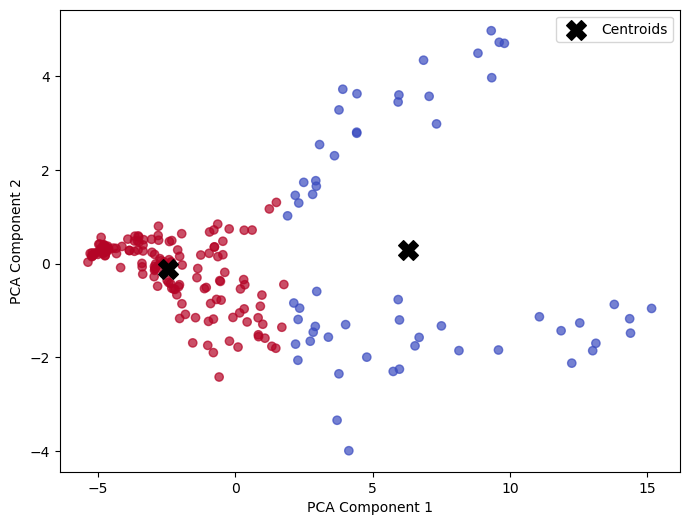

In [23]:
plt.figure(figsize=(8, 6))
plt.scatter(test_PCA_thetabeta[:, 0], test_PCA_thetabeta[:, 1], c=cluster_labels, cmap="coolwarm", alpha=0.7)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c="black", marker="X", s=200, label="Centroids")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()

Иако не е воопшто 'висока', точноста на лабелите назначени од едноставен K-Means кластеринг со 2 центроиди е изнедувачка, а самите податоци, нацртани како точки на рамнина чии димензии ги претставуваат нивните први 2 компоненти во PCA, покажуваат извесно групирање на пациентите со АДХД во две 'oпашки' кои извираат од централниот кластер каде се наоѓаат сите здрави пациенти. Важно е да се забележи дека нема ниту еден здрав пациент во опашките.

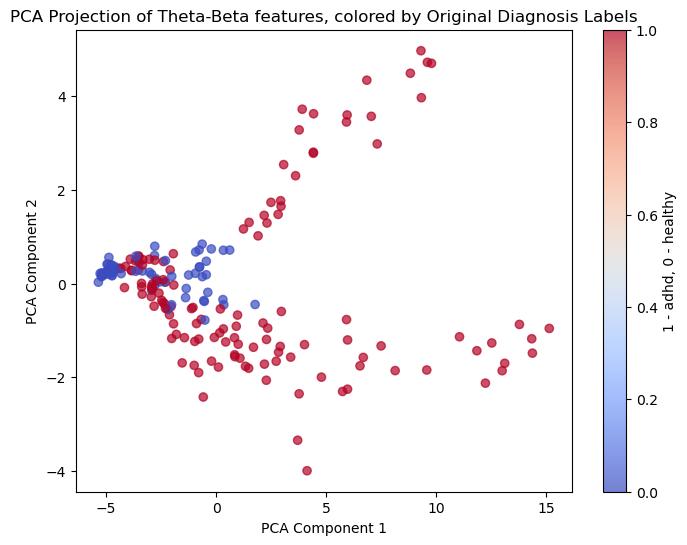

In [71]:
plt.figure(figsize=(8, 6))
plt.scatter(test_PCA_thetabeta[:, 0], test_PCA_thetabeta[:, 1], c=y_test, cmap="coolwarm", alpha=0.7)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA Projection of Theta-Beta features, colored by Original Diagnosis Labels")
plt.colorbar(label='1 - adhd, 0 - healthy')
plt.show()

#### 1.2 DBSCAN

За да процениме колку добро би можеле да ги опфатиме формите на кластерите користејќи го DBSCAN, ги тунраме параметрите 'eps' 'min_samples' на таков начин што би добиле 2 кластера. 

In [38]:
from sklearn.cluster import DBSCAN

In [62]:
dbscan = DBSCAN(eps=0.5, min_samples=9) 
clusters = dbscan.fit_predict(test_PCA_thetabeta)

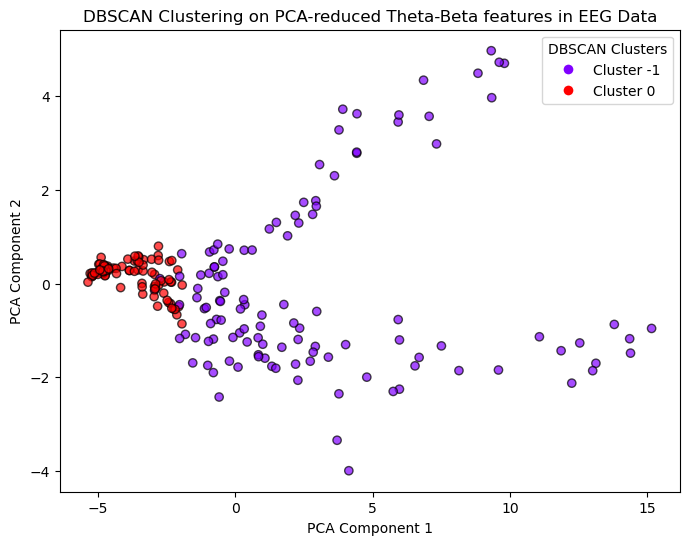

In [72]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(test_PCA_thetabeta[:, 0], test_PCA_thetabeta[:, 1], c=clusters, cmap='rainbow', alpha=0.7, edgecolors='k')
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("DBSCAN Clustering on PCA-reduced Theta-Beta features in EEG Data")

unique_clusters = np.unique(clusters)
legend_labels = {c: f"Cluster {c}" for c in unique_clusters}
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(c)), markersize=8, label=legend_labels[c]) for c in unique_clusters], title="DBSCAN Clusters")

plt.show()


In [67]:
clusters_labels_dbscan = [1 if clusters[i] == -1 else 0 for i in range(len(clusters))]

In [68]:
accuracy_score(y_test, clusters_labels_dbscan)

0.6875

Точноста се подобрува за неколку проценти, но поради измешаноста на точките во централниот кластер, не може да биде подобра од ~70%.

### 2. Кластерирање според вредности за Јортова активност во каналите: F3, Fz, F4, FC3, C3, Cz, C4, CP3, CPz, CP4

Занимливо е што според графиците од претходните визуелизации, кај повеќето испитаници со АДХД се јавуваат повисоки вредности за Јортова активност во централните и фронталните електроди, што соодвествуваат на тие делови од мозокот (асоцирани со учење, решавање на проблеми итн.). 

In [77]:
testing_df_hjorth = testing_df_final.filter(regex='activity')

#### 2.1 - K-Means (k=2) 

In [78]:
pca = PCA(n_components=0.95)
testing_df_hjorth = scaler.fit_transform(testing_df_hjorth)
test_PCA_hjorth = pca.fit_transform(testing_df_hjorth)

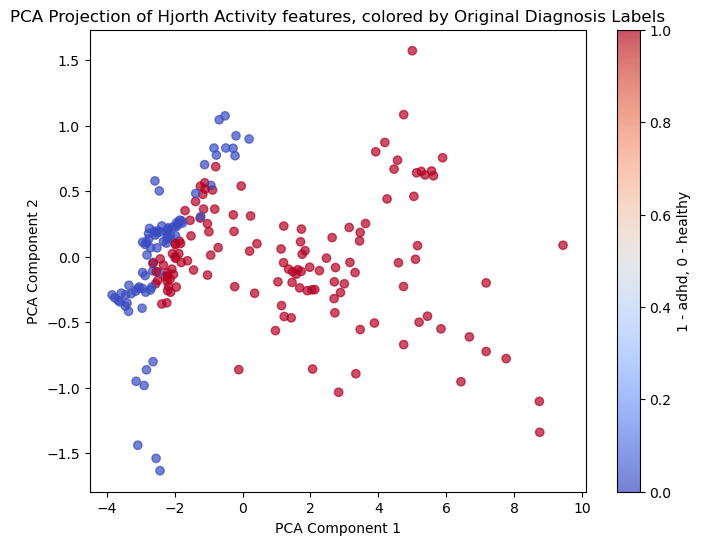

In [79]:
plt.figure(figsize=(8, 6))
plt.scatter(test_PCA_hjorth[:, 0], test_PCA_hjorth[:, 1], c=y_test, cmap="coolwarm", alpha=0.7)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA Projection of Hjorth Activity features, colored by Original Diagnosis Labels")
plt.colorbar(label='1 - adhd, 0 - healthy')
plt.show()

Разиката меѓу пациентите со, и без АДХД е уште поочигледна кога ја користиме Јортовата активност како влез во PCA за исцртување на точките, сепак, има малцинство од АДХД-означени точки кои имаат слични врености за Јортова активност како тие означени како здрави. 

In [80]:
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(test_PCA_hjorth)

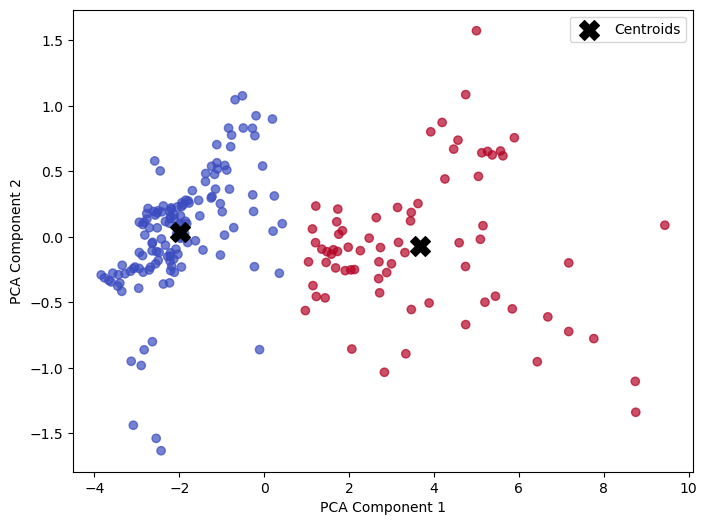

In [81]:
plt.figure(figsize=(8, 6))
plt.scatter(test_PCA_hjorth[:, 0], test_PCA_hjorth[:, 1], c=cluster_labels, cmap="coolwarm", alpha=0.7)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c="black", marker="X", s=200, label="Centroids")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()

In [ ]:
accuracy_score(y_test, cluster_labels) # Има значајно зголемување на точноста во кластерирањето

0.7259615384615384

Се чини дека Јортовата активност може да биде  доста добар биомаркер за детекција на АДХД од ЕЕГ сигнали. Ќе пробаме да фитуваме логистичка регресија на податоците, и да пробаме да ги класифицираме така. 

In [102]:
training_df_hjorth = training_df_final.filter(regex='activity|diagnosis')
validation_df_hjorth = validation_df_final.filter(regex='activity|diagnosis')
y_train = training_df_hjorth['diagnosis']
y_val = validation_df_hjorth['diagnosis']

training_df_hjorth.drop(columns=['diagnosis'], inplace=True)
validation_df_hjorth.drop(columns=['diagnosis'], inplace=True)

/tmp/ipykernel_2911/3550851782.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_df_hjorth.drop(columns=['diagnosis'], inplace=True)
/tmp/ipykernel_2911/3550851782.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_df_hjorth.drop(columns=['diagnosis'], inplace=True)


[I 2025-02-10 00:17:45,044] A new study created in memory with name: no-name-830c3351-51c0-4592-a601-5a6459bc8826
/tmp/ipykernel_2911/4262452021.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 1e-4, 1e2)
[I 2025-02-10 00:17:45,048] Trial 0 finished with value: 0.9384615384615385 and parameters: {'C': 38.24996136146357}. Best is trial 0 with value: 0.9384615384615385.
/tmp/ipykernel_2911/4262452021.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 1e-4, 1e2)
[I 2025-02-10 00:17:45,050] Trial 1 finished with value: 0.9384615384615385 and parameters: {'C': 0.47138952133987605}. Best is trial 0 with v

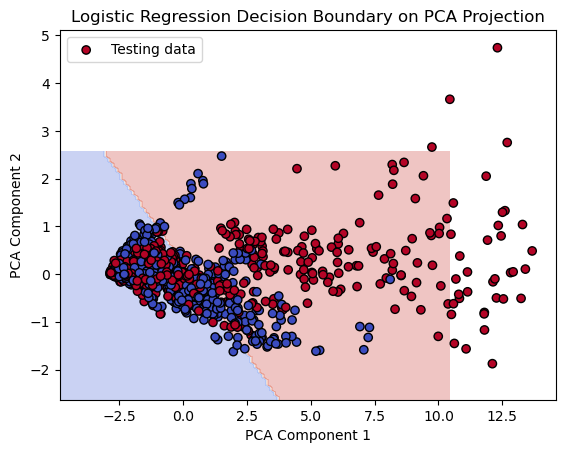

In [110]:
scaler = StandardScaler()
pca = PCA(n_components=2) 
X_train_pca = pca.fit_transform(scaler.fit_transform(training_df_hjorth))
X_val_pca = pca.transform(scaler.transform(validation_df_hjorth))

def objective(trial):
    C = trial.suggest_loguniform("C", 1e-4, 1e2)
    model = LogisticRegression(C=C, max_iter=500, solver="liblinear")
    model.fit(X_train_pca, y_train)
    y_pred = model.predict(X_val_pca)
    return accuracy_score(y_val, y_pred)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)
best_C = study.best_params["C"]

best_model = LogisticRegression(C=best_C, max_iter=500, solver="liblinear")
best_model.fit(X_train_pca, y_train)

y_test_pred = best_model.predict(test_PCA_hjorth)

xx, yy = np.meshgrid(np.linspace(test_PCA_hjorth[:, 0].min()-1, test_PCA_hjorth[:, 0].max()+1, 100),
                     np.linspace(test_PCA_hjorth[:, 1].min()-1, test_PCA_hjorth[:, 1].max()+1, 100))

Z = best_model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='coolwarm', edgecolors='k', label="Testing data")
plt.title("Logistic Regression Decision Boundary on PCA Projection")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()



Иако резултатите се скромни, границата на одлучување за логистичката регресија е токму онаму каде што ја очекуваме, некаде на границата меѓу кластерите опишани со првичната PCA визуелизација. 

In [108]:
y_test_pred = best_model.predict(test_PCA_hjorth)

In [109]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.56      0.88      0.68        78
           1       0.89      0.58      0.70       130

    accuracy                           0.69       208
   macro avg       0.72      0.73      0.69       208
weighted avg       0.77      0.69      0.69       208

